In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
df = pd.read_csv("../data/btcusdt.csv")
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore
0,2022-01-01 08:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,1641081599999,9.241552e+08,714899,9942.36679,4.687387e+08,0
1,2022-01-02 08:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,1641167999999,8.666110e+08,709624,9166.46954,4.331824e+08,0
2,2022-01-03 08:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1641254399999,1.292204e+09,885624,13524.76045,6.318794e+08,0
3,2022-01-04 08:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1641340799999,1.649170e+09,1021815,17689.26808,8.217255e+08,0
4,2022-01-05 08:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,1641427199999,2.334289e+09,1478532,23552.99460,1.063287e+09,0


The trading strategy is simple:
- Long the stock if the shorter SMA > longer SMA
- Short  the stock if the shorter SMA < longer SMA

In [18]:
short_sma = 30
long_sma = 240

In [19]:
df['SMA1'] = df['Close'].rolling(short_sma).mean()
df['SMA2'] = df['Close'].rolling(long_sma).mean()
# drop the rows with NaN entries
df.dropna(inplace=True)
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore,SMA1,SMA2


In [20]:
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [21]:
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore,SMA1,SMA2,Position


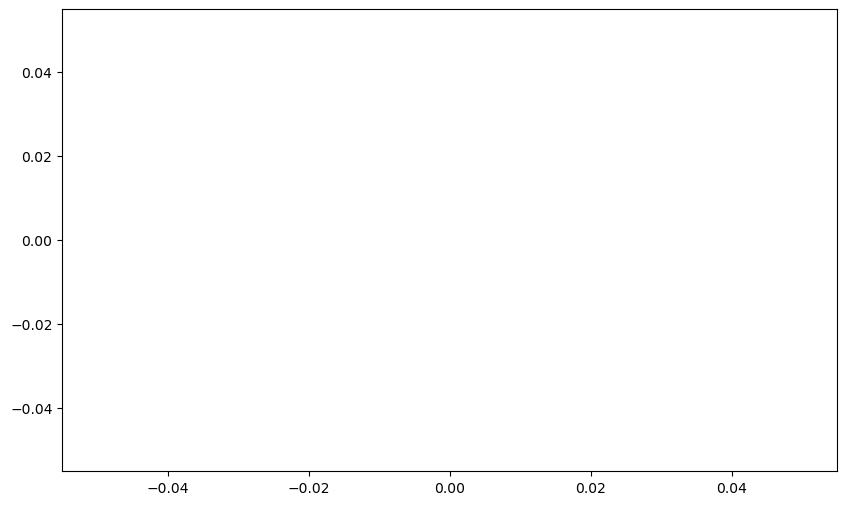

In [22]:
ax = df['Position'].plot(figsize=(10,6))

## Machine Learning Approach: Classification

Another strategy is that we compute the log returns for each consecutive timestamps.

In [23]:
df = pd.read_csv("../data/btcusdt.csv")
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore
0,2022-01-01 08:00:00,46216.93,47954.63,46208.37,47722.65,19604.46325,1641081599999,9.241552e+08,714899,9942.36679,4.687387e+08,0
1,2022-01-02 08:00:00,47722.66,47990.00,46654.00,47286.18,18340.46040,1641167999999,8.666110e+08,709624,9166.46954,4.331824e+08,0
2,2022-01-03 08:00:00,47286.18,47570.00,45696.00,46446.10,27662.07710,1641254399999,1.292204e+09,885624,13524.76045,6.318794e+08,0
3,2022-01-04 08:00:00,46446.10,47557.54,45500.00,45832.01,35491.41360,1641340799999,1.649170e+09,1021815,17689.26808,8.217255e+08,0
4,2022-01-05 08:00:00,45832.01,47070.00,42500.00,43451.13,51784.11857,1641427199999,2.334289e+09,1478532,23552.99460,1.063287e+09,0


In [24]:
df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

In [25]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, 3):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
    print('The following columns have been added: \n')
    print(cols)

In [26]:
create_lags(df)

The following columns have been added: 

['lag_1', 'lag_2']


In [27]:
df.dropna(inplace=True)

In [28]:
split = int(len(df) * 0.80)

In [29]:
train = df.iloc[:split].copy()
train.shape

(168, 16)

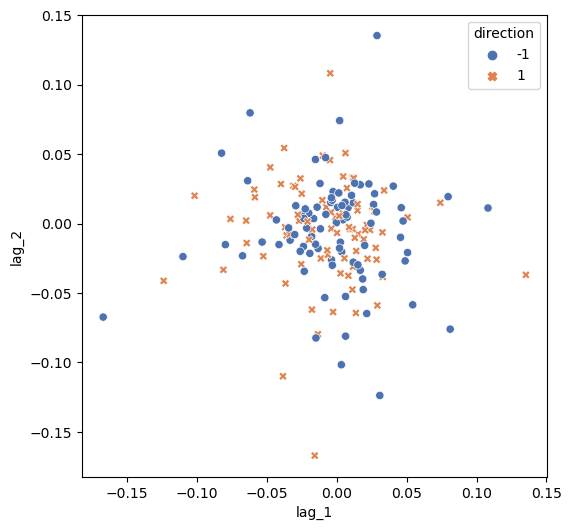

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(6,6))
fig = sns.scatterplot(data=train, x="lag_1", y="lag_2", hue="direction", style="direction", palette="deep")

For our logistic regression model, 

$$
z = \overrightarrow{w} \cdot \overrightarrow{x} + b
$$

From the raw features data, we transformed into a polynomial with terms $x_1$ and $x_2$, 
which represents `lag_1` and `lag_2` respectively.

$$
y = w_1 x_1 + w_2 x_2 + w_3 x_1^2 + \cdots + w_n x_1^7 x_2^8
$$

In [31]:
import sys
sys.path.append('../')

from utils import *

X_mapped = map_feature(train.lag_1, train.lag_2)
X_mapped

array([[-1.79255747e-02, -9.18805274e-03,  3.21326229e-04, ...,
         1.93324571e-16,  9.90917381e-17,  5.07911255e-17],
       [-1.33097452e-02, -1.79255747e-02,  1.77149317e-04, ...,
         5.87730212e-15,  7.91555487e-15,  1.06606752e-14],
       [-5.33458970e-02, -1.33097452e-02,  2.84578473e-03, ...,
         1.58205104e-14,  3.94720071e-15,  9.84822426e-16],
       ...,
       [ 3.30314965e-03, -1.01630178e-01,  1.09107976e-05, ...,
         1.20224402e-11, -3.69902325e-10,  1.13810282e-08],
       [-7.60018363e-02,  3.30314965e-03,  5.77627913e-03, ...,
         7.50270161e-18, -3.26078256e-19,  1.41718323e-20],
       [ 8.11277149e-02, -7.60018363e-02,  6.58170613e-03, ...,
         1.26847818e-09, -1.18833214e-09,  1.11324995e-09]])

In [32]:
# Initialize fitting parameters
np.random.seed(42)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

y_train = train.direction.to_numpy()

w,b, J_history,_ = gradient_descent(z_scaler(X_mapped), y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     1.48   
Iteration 1000: Cost     0.02   
Iteration 2000: Cost    -0.11   
Iteration 3000: Cost    -0.18   
Iteration 4000: Cost    -0.24   
Iteration 5000: Cost    -0.29   
Iteration 6000: Cost    -0.35   
Iteration 7000: Cost    -0.39   
Iteration 8000: Cost    -0.44   
Iteration 9000: Cost    -0.49   
Iteration 9999: Cost    -0.54   


once computed, the fitting parameters are

In [33]:
w

array([-1.07611860e+00,  7.80806691e-02, -4.01010015e+00, -2.34008275e-01,
       -2.01928824e+00, -6.38440527e-02, -5.09264964e-01,  8.84487895e-02,
       -3.65367753e-01, -4.09090716e-02, -6.90321618e-01,  2.71667591e-01,
        1.60114747e-01, -4.54801198e-01, -4.86556304e-01, -4.94972652e-01,
       -3.75964720e-01, -1.56863488e-01, -2.52468449e-01, -4.00666618e-01,
       -7.18957008e-02, -5.43446639e-01, -3.90239113e-01, -3.15798473e-01,
       -2.26088306e-01,  1.03280739e-01, -4.81458441e-01, -1.67465885e-01,
       -8.95422312e-02, -6.35563521e-01, -7.45047482e-02, -5.11538802e-01,
       -6.17019047e-01,  2.66765939e-01,  2.83278603e-01,  1.26280267e-01,
       -3.77479435e-01, -5.84405595e-01,  2.16019382e-03, -2.41918443e-01,
       -5.60031452e-01, -1.86892929e-01, -6.47676880e-01,  2.27284034e-01])

/home/pehcy/projects/binoculars/src/notebook/../utils.py:5: RuntimeWarning: overflow encountered in exp
  g = 1 / (1 + np.exp(np.negative(z)))


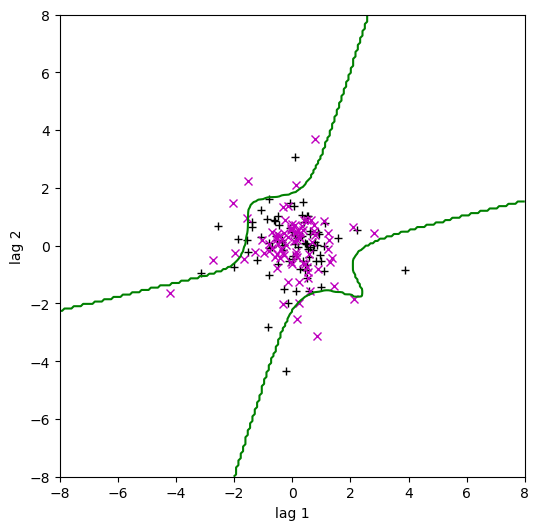

In [34]:
is_positive = train[train['direction'] > 0]
is_negative = train[train['direction'] <= 0]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(z_scaler(is_positive['lag_1']), z_scaler(is_positive['lag_2']), 'k+')
ax.plot(z_scaler(is_negative['lag_1']), z_scaler(is_negative['lag_2']), 'mx')
plt.xlabel('lag 1')
plt.ylabel('lag 2')
plot_decision_boundary(ax, w, b, z_scaler(X_mapped), y_train)